In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plot
plot.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
# Two auxiliary functions that we will use. You do not need to read them (but make sure to run this cell!)

# Function that construct a matrix whose columns are the vectors of the Haar wavelet basis in dimension n=2**d
def haar(d):
    n = 2**d
    m = np.zeros((n,n))
    l = 1
    for i in range(d):
        k = int(n / (2*l))
        for j in range(k):
            m[2*j*l : 2*j*l + l, j+n-2*k] = 1 / np.sqrt(2*l)
            m[2*j*l+l : 2*(j+1)*l, j+n-2*k, ] = -1 / np.sqrt(2*l)
        l = 2*l
    m[:,-1] = 1 / np.sqrt(n)
    return m

def plot_vector(v):
    plot.plot(v,linestyle='', marker='o',color='black')

# 1. Haar Wavelets

## 1.1. The canonical basis

The vectors of the canonical basis are the columns of the identity matrix in dimension $n$. We plot their coordinates below for $n=8$.

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

 Nothing new so far...


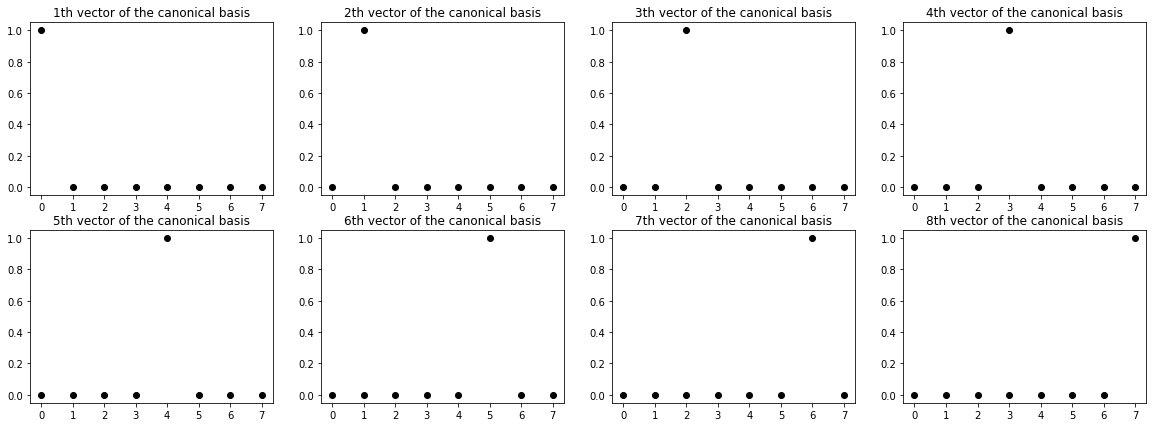

In [4]:
identity = np.identity(8)
print(identity)

plot.figure(figsize=(20,7))
for i in range(8):
    plot.subplot(2,4,i+1)
    plot.title(f"{i+1}th vector of the canonical basis")
    plot_vector(identity[:,i])
    
print('\n Nothing new so far...')

## 1.2. Haar wavelet basis

Haar wavelets basis is another basis of $\mathbb{R}^n$ when $n$ is a power of 2, that is $n=2^k$ for some $k$. The function `haar(k)` outputs a square matrix of dimension $n = 2^k$ whose columns are the vectors of the Haar wavelet basis.

[[ 0.707  0.     0.     0.     0.5    0.     0.354  0.354]
 [-0.707  0.     0.     0.     0.5    0.     0.354  0.354]
 [ 0.     0.707  0.     0.    -0.5    0.     0.354  0.354]
 [ 0.    -0.707  0.     0.    -0.5    0.     0.354  0.354]
 [ 0.     0.     0.707  0.     0.     0.5   -0.354  0.354]
 [ 0.     0.    -0.707  0.     0.     0.5   -0.354  0.354]
 [ 0.     0.     0.     0.707  0.    -0.5   -0.354  0.354]
 [ 0.     0.     0.    -0.707  0.    -0.5   -0.354  0.354]]


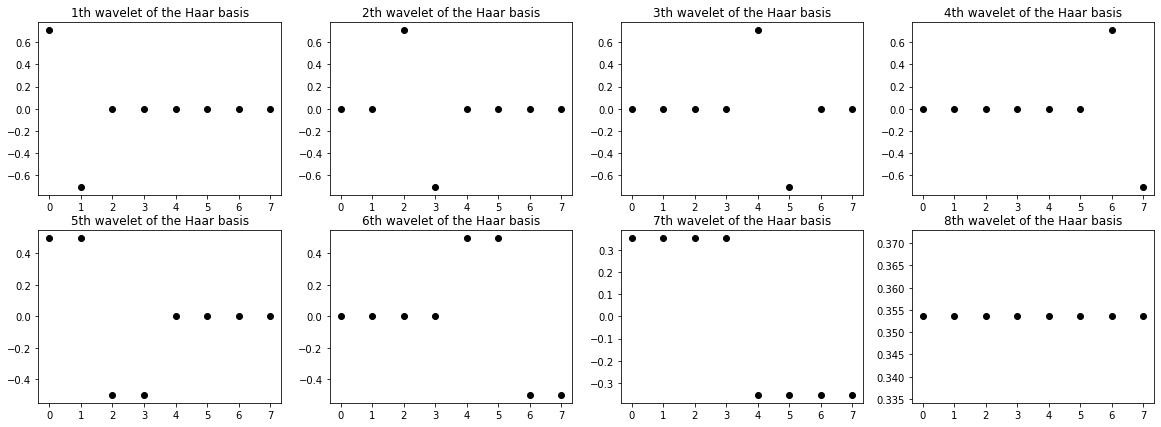

In [6]:
# Matrix of Haar wavelets in dimension n = 2**3 = 8
H8 = haar(3)
print(np.round(H8,3))

plot.figure(figsize=(20,7))

for i in range(8):
    plot.subplot(2,4,i+1)
    plot.title(f"{i+1}th wavelet of the Haar basis")
    plot_vector(H8[:,i])

**(a)** Check numerically (in one line of code) that the columns of `H8` are an orthonormal basis of $\mathbb{R}^8$ (ie verify that the Haar wavelet basis is an orthonormal basis).

In [ ]:
# Your answer here

The vectors of the Haar wavelet basis are called **wavelets**.

Given a vector $x \in \mathbb{R}^n$, the coordinates of $x$ in the wavelet Haar basis are called the **wavelet coefficients** of $x$.

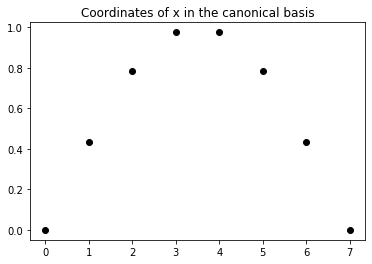

In [7]:
# Let consider the following vector x
x = np.sin(np.linspace(0,np.pi,8))
plot.title('Coordinates of x in the canonical basis')
plot_vector(x)

**(b)** Compute the vector $v \in \mathbb{R}^8$ of wavelet coefficients of $x$. (1 line of code!)

How can we obtain back $x$ from $v$ ? (1 line of code!).

In [ ]:
# Write your answer here

# 2. Image compression
In this section, we will use Haar wavelets to compress images

In [8]:
# Reading the image file
img_RGB = plot.imread('sleeping.jpg')
h,w,d = img_RGB.shape
print(f'Height: {h}, Width: {w}, Number of channels: {d} (Red, Green, Blue)')

Height: 2934, Width: 4500, Number of channels: 3 (Red, Green, Blue)


The 'image tensor' `img_RGB` contains 3 matrices: `img_RGB[:,:,0]`, `img_RGB[:,:,1]` and `img_RGB[:,:,2]`, giving for each pixel the amount of red, green and blue.

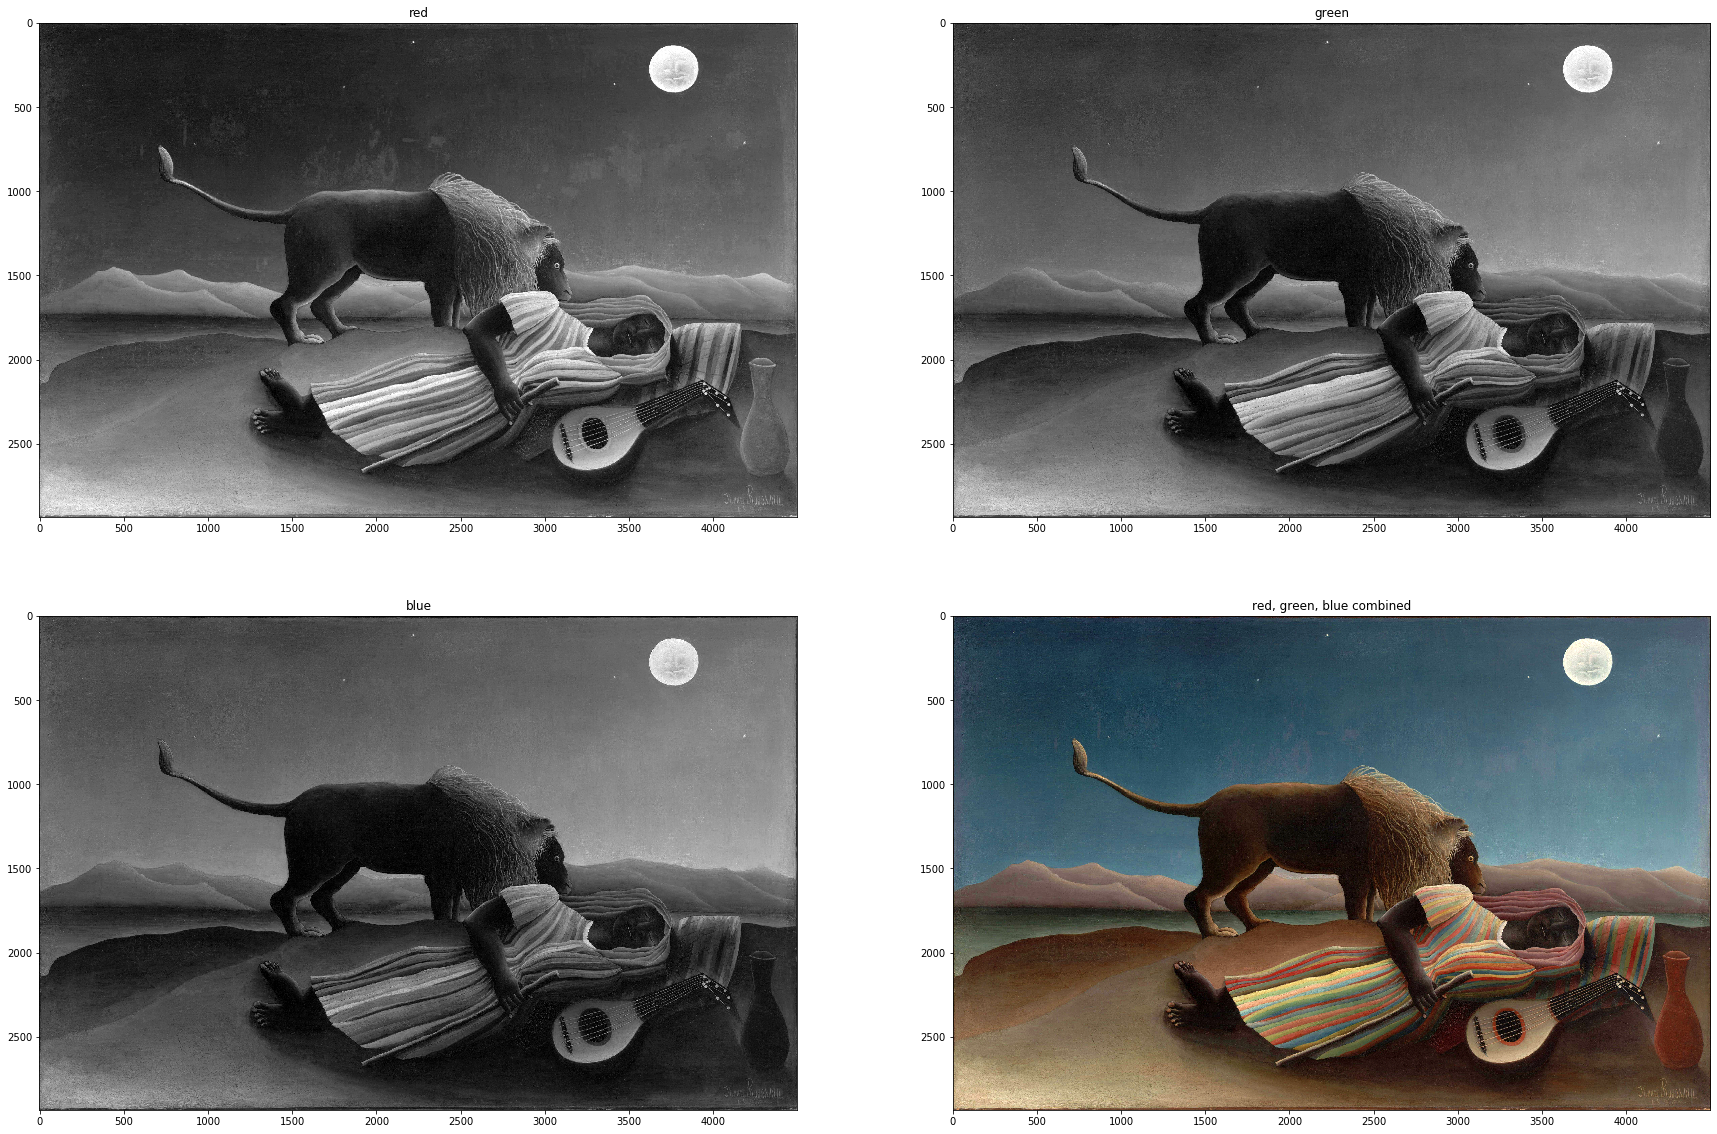

In [10]:
plot.figure(figsize=(30,20))
colors = ['red','green','blue']
for i in range(3):
    plot.subplot(2, 2, i+1)
    plot.title(colors[i])
    plot.imshow(img_RGB[:,:,i])
plot.subplot(2,2,4)
plot.title('red, green, blue combined')
plot.imshow(img_RGB)
plot.show()

Our goal is to compress and denoise such RGB images. **For simplicity, we will do it for only one of the three colors:** 

In [11]:
image = img_RGB[:,:,1] # Consider the gree component only

It will be much more convenient to use images whose dimensions are powers of 2. Hence we crop the original image:

The image is now 2048 x 4096


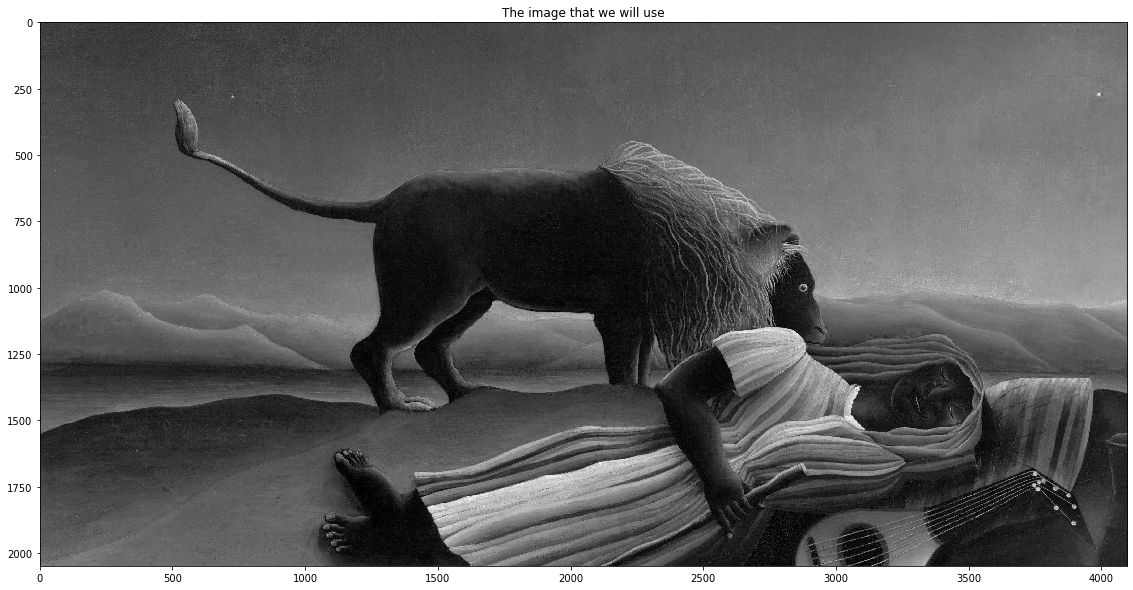

In [12]:
def power2crop(img):
    height, width= img.shape
    height2, width2 = 2**int(np.log2(height)), 2**int(np.log2(width))
    padh, padv= int((height-height2)/2), int((width-width2)/2)
    return img[padh:padh+height2, padv:padv+width2]

image = power2crop(image)
print(f'The image is now {image.shape[0]} x {image.shape[1]}')

# plot image
plot.figure(figsize=(20,10))
plot.title('The image that we will use')
plot.imshow(image)
plot.show()

# Image compression
We will use the Haar wavelet basis to compress our image.
We will see each column of pixels as a vector in $\mathbb{R}^{2048}$, and compute their coordinates in the Haar wavelet basis of $\mathbb{R}^{2048}$.

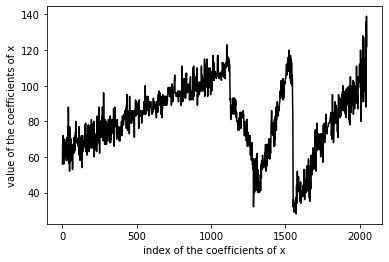

In [13]:
H = haar(11) # matrix of the Haar basis of dimension 2**11 = 2048
x = image[:,0]

# Plot the entries of x, the first column of our image
plot.plot(x,color='black')
plot.xlabel('index of the coefficients of x')
plot.ylabel('value of the coefficients of x')
plot.show()

**(c)** Compute the vector `v` of the coordinates of `x` in the Haar basis, and plot its entries.

Explain intuitively why there are only few coefficients of significant magnitude.

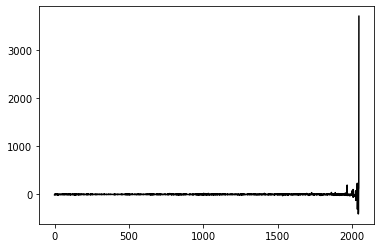

In [14]:
v = H.T @ x

plot.plot(v,color='black')
plot.show()

**(d)** Compute the 2048 x 4096 matrix `wavelet_coeffs` whose columns are the wavelet coefficients of the columns of `image`.

In [17]:
wavelet_coeffs = H.T @ image

Since a large fraction of the wavelet coefficients seems to be negligible, we see that the vector `v` can be well approximated by a linear combination of a small number of wavelets.

Hence, we can 'compress' the image by only storing a few wavelet coefficients of largest magnitude.

Let say that we want to reduce the size by $97\%$:
Store only the top $3\%$ largest (in absolute value) coefficients of `wavelet_coeffs.

**(e)** Compute a matrix `thres_coeffs` who is the matrix `wavelet_coeffs` where about $97\%$ smallest entries have been put to 0.

In [18]:
thres_coeffs = wavelet_coeffs.copy()
mask = (np.abs(wavelet_coeffs) < 42)
thres_coeffs[mask] = 0
h,w = thres_coeffs.shape
print(np.sum(mask)/ (h*w))

0.97062087059021


**(f)** Compute and plot the `compressed_image` corresponding to `thres_coeffs`.

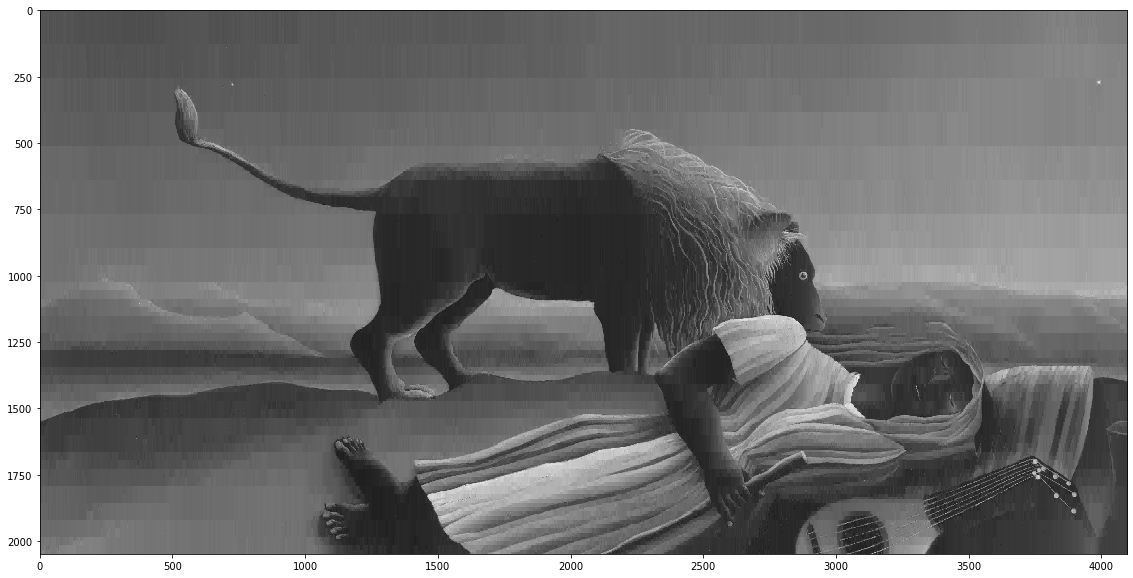

In [19]:
compressed_image = H @ thres_coeffs

plot.figure(figsize=(20,10))
plot.imshow(compressed_image)
plot.show()

# 3. Image denoising

**From now on, we will work with the `compressed_image` computed in the previous section, for which about $97\%$ of wavelet coefficients are 0.** (We make this choice only in order to make the analysis easier).

We suppose that our `compressed_image` has been corrupted by some Gaussian noise of variance $\sigma$:

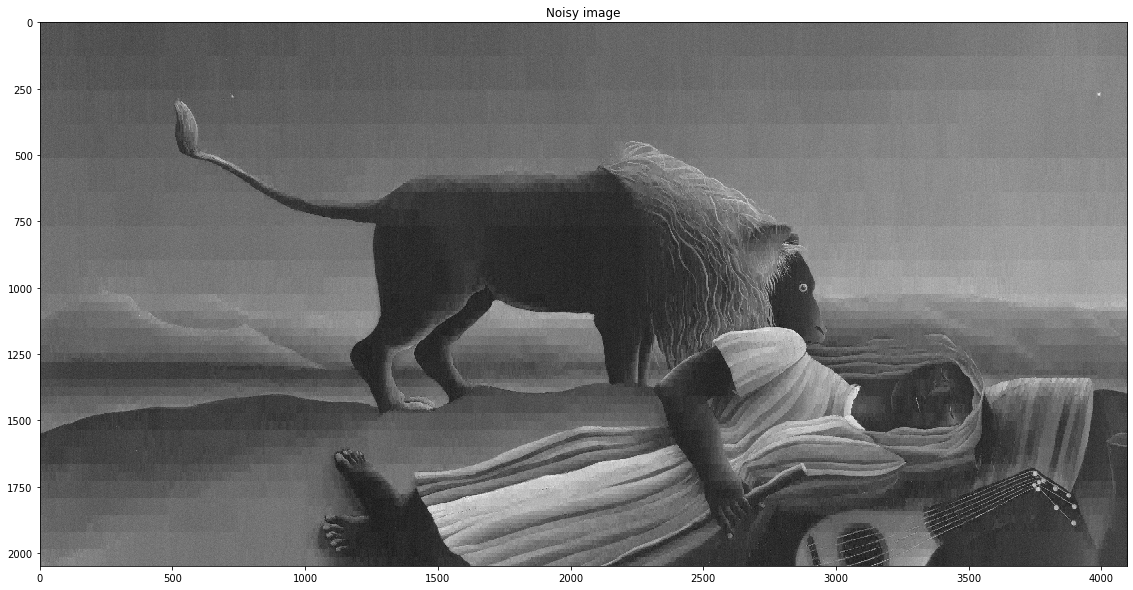

In [21]:
sigma=5
Z=np.random.normal(size=compressed_image.shape) # matrix filled with independent standard Gaussian random variables

noisy_image = compressed_image + sigma * Z

plot.figure(figsize=(20,10))
plot.imshow(noisy_image)
plot.title('Noisy image')
plot.show()

## Theoretical analysis

We would like to denoise the `noisy_image`.
Again, we will denoise each column separately.

Let $x$ be a column of the `compressed_image` and $y$ the corresponding column of `noisy_image`.
Then we have
$$
y_j = x_j + \sigma z_j
$$
where the $z_j$ are iid $\mathcal{N}(0,1)$.

Without knowledge of the structure of $x$, one can not really improve on the stupid estimator $\hat{x}_{\rm stupid} = y$ that achieve and error
$$
\| x - \hat{x}_{\rm stupid} \|^2 = \| \sigma z \|^2 \simeq \sigma^2 N,
$$
where $N=2048$ is the height of the image.
We see here that the error grows linearly in $N$, which is an issue, when $N$ is very large.

However, we know from the previous section that $x$ is 'sparse in the wavelet basis', ie **a large fraction of the wavelet coefficients of $x$ are 0**. Only $s$ wavelet coefficients of $x$ are non-zero (here, we have $s \simeq 0.03 \times N$).


Using this information we will construct in the following an estimator $\hat{x}$ for which
$$
\| x - \hat{x} \|^2 \leq 8 \sigma^2 s \log(N),
$$

In many situation, $s << N$, hence this denoising procedure leads to a huge improvement.

The key is again to study the problem in the Haar wavelet basis.
Let $v$ and $w$ be the coefficients of respectively $x$ and $y$ in the Haar wavelet basis. 
**Optional**: Justify that
$$
w_j = v_j + \sigma \epsilon_j
$$
where the $\epsilon_j$ are iid $\mathcal{N}(0,1)$.

Probability theory tells us that
$$
\max \epsilon_i \simeq \sqrt{2 \log(N)},
$$
hence we will assume in the sequel that $|\epsilon_i| \leq \sqrt{2 \log(N)}$ for all $i$.
It has been proposed to estimate $v$ from $w$ by "soft-thresholding" the coefficient of $v$:
$$
\hat{v}_j = 
\eta\Big(v_j, \sigma \sqrt{2 \log N}\Big)
=
\begin{cases}
0 & \text{if} \ |v_j| \leq \sigma \sqrt{2 \log N} \\
v_j - \sigma \sqrt{2 \log N} & \text{if} \ v_j \geq \sigma \sqrt{2 \log N} \\
v_j + \sigma \sqrt{2 \log N} & \text{if} \ v_j \leq - \sigma \sqrt{2 \log N}
\end{cases}
$$
(we basically set the coefficients smaller than $\sigma \sqrt{2 \log N}$ to zero, but in order to create discontinuities, we also shrink the larger coefficients).

**(g)** Give an intuitive motivation for the procedure above.

Write your answer here (for a nicer display chose Cell > Cell Type > Markdown, this also allows you to use LaTeX symbols)

**(h)** Justify that 
$$
\|v - \hat{v} \|^2 \leq 8 \sigma^2 s \log(N),
$$
and deduce and estimator $\hat{x}$ such that
$$
\|x - \hat{x} \|^2 \leq 8 \sigma^2 s \log(N).
$$

In [ ]:
Write your answer here

## Application
**(i)** Apply the method studied above to denoise the `noisy_image`.
You have to compute and plot a matrix `denoised_image`.

We give below the soft-thresholding function $\eta$:

In [22]:
def soft_thresholding(data,value):
    return data/np.abs(data) * np.maximum(np.abs(data) - value, 0)

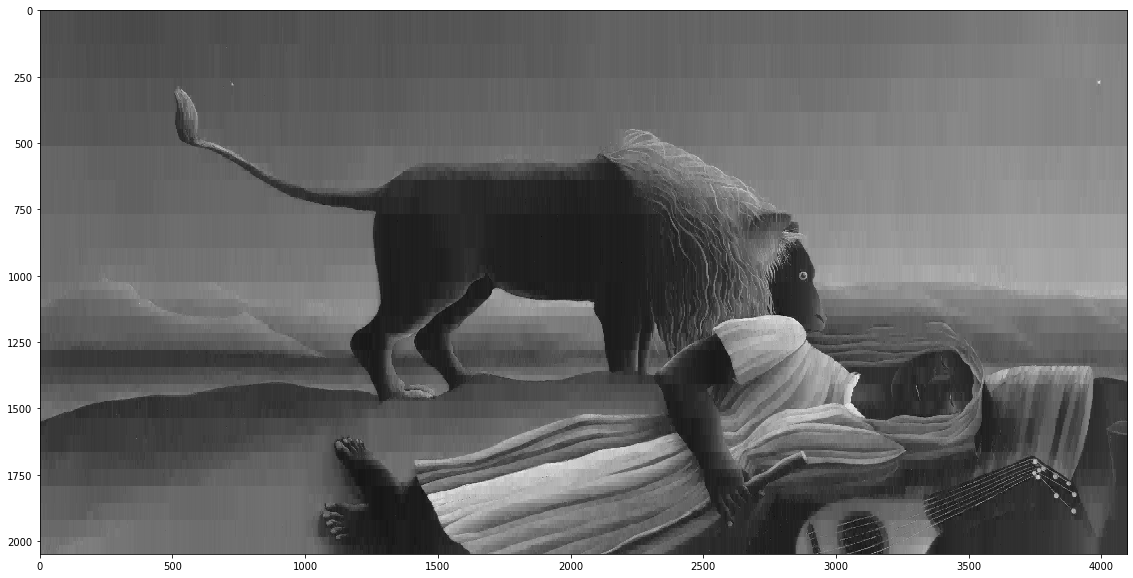

In [23]:
# Your answer here
N, _ = noisy_image.shape
t = sigma*np.sqrt(2*np.log(N))
v_hat = soft_thresholding(H.T @ noisy_image,t)
denoised_image = H @ v_hat

plot.figure(figsize=(20,10))
plot.imshow(denoised_image)
plot.show()

We check below that the `denoised_image` is closer from `compressed_image` than `noisy_image`:

In [24]:
def square_error(img1,img2):
    h,w = img1.shape
    return np.sum(np.square(img1-img2)) /(h*w)

error_naive = square_error(noisy_image, compressed_image)
error_denoised = square_error(denoised_image, compressed_image)

print(f'Error of the naive estimator: {error_naive} (this should be close to sigma**2)')
print(f'Error of the denoised image: {error_denoised}')

Error of the naive estimator: 24.97975236726428 (this should be close to sigma**2)
Error of the denoised image: 11.961792879079923


# Concluding remarks

You should observe that the error achieved by the `denoised_image` is about the half of the one of the naive estimator.

This is very nice. In practice, one can do much better:

- There exists **better thresholds** than $\sigma \sqrt{2 \log(N)}$, that leads to a smaller error.
- In practice, we do not perform the wavelet decomposition over the columns (of size 2048) but over the all image using **'2D' wavelets**. Instead of having $N=2048$ we have now $N = 2048 \times 4096$, hence the improvement from $\sigma^2 N$ to $8 \sigma^2 s \log(N)$ is much bigger.
- Using 2D-wavelets would also remove many of the 'horizontal edges' that we see on the compressed and denoised images.
- Here, we used for simplicity the Haar wavelets, but there exists **other wavelets** that are better for image compression/denoising. By 'better', we mean 'sparser images wavelet coefficients': the sparser $v$ is, the smaller $s$ is in the bound $ \leq 8 \sigma^2 s \log(N)$.
- Ultimately, it is possible to **'learn' a good basis** in which images are sparse, see for instance this [tutorial](http://lear.inrialpes.fr/people/mairal/tutorial_cvpr2010/).